#데이터


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ryul2004","key":"21fd1595d661e1c446d8e6643d340db1"}'}

In [ ]:
!kaggle datasets download alistairking/recyclable-and-household-waste-classification

Dataset URL: https://www.kaggle.com/datasets/alistairking/recyclable-and-household-waste-classification
License(s): MIT
 99% 915M/920M [00:07<00:00, 149MB/s]
100% 920M/920M [00:07<00:00, 126MB/s]


In [ ]:
import zipfile
import os

def unzip_file(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# 사용 예시
zip_path = '/content/recyclable-and-household-waste-classification.zip'  # 압축 파일 경로
extract_to = 'data'  # 파일을 해제할 폴더 경로

# 디렉토리가 없다면 생성
if not os.path.exists(extract_to):
    os.makedirs(extract_to)

unzip_file(zip_path, extract_to)

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import random

In [ ]:
def set_seed():
  random.seed(17)

In [ ]:
class WasteDataset(Dataset):
    def __init__(self, root_dir, split, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []

        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for subfolder in ['default', 'real_world']:
                subfolder_dir = os.path.join(class_dir, subfolder)
                image_names = os.listdir(subfolder_dir)
                random.shuffle(image_names)

                if split == 'train':
                    image_names = image_names[:int(0.6 * len(image_names))]
                elif split == 'val':
                    image_names = image_names[int(0.6 * len(image_names)):int(0.8 * len(image_names))]
                else:  # split == 'test'
                    image_names = image_names[int(0.8 * len(image_names)):]

                for image_name in image_names:
                    self.image_paths.append(os.path.join(subfolder_dir, image_name))
                    self.labels.append(i)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# 모델


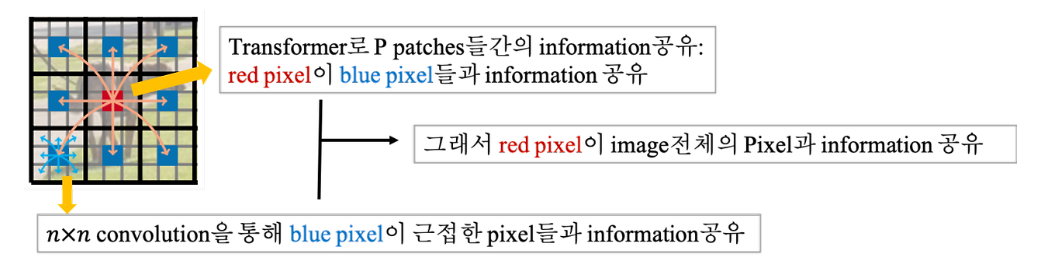



In [ ]:
import torch
import torch.nn as nn

from einops import rearrange


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.SiLU()
    )

def conv_nxn_bn(inp, oup, kernal_size=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernal_size, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.SiLU()
    )

#새로 추가된 부분
def conv5x5_bn(inp, oup, kernal_size=5, stride=1):
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernal_size, stride=stride, padding=2, bias=False),  # padding=2로 설정
        nn.BatchNorm2d(oup),
        nn.SiLU()
    )

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b p n (h d) -> b p h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = self.attend(dots)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b p h n d -> b p n (h d)')
        return self.to_out(out)


class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads, dim_head, dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x


class MV2Block(nn.Module):
    def __init__(self, inp, oup, stride=1, expansion=4):
        super().__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(inp * expansion)
        self.use_res_connect = self.stride == 1 and inp == oup

        if expansion == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileViTBlock(nn.Module):
    def __init__(self, dim, depth, channel, kernel_size, patch_size, mlp_dim, dropout=0.):
        super().__init__()
        self.ph, self.pw = patch_size

        self.conv1 = conv_nxn_bn(channel, channel, kernel_size)
        self.conv2 = conv_1x1_bn(channel, dim)

        self.conv1_5 = conv5x5_bn(channel, channel)
        self.conv2_5 = conv_1x1_bn(channel, dim)

        self.conv_after_concat = conv_1x1_bn(2 * dim, dim)

        self.transformer = Transformer(dim, depth, 4, 8, mlp_dim, dropout)

        self.conv3 = conv_1x1_bn(dim, channel)
        self.conv4 = conv_nxn_bn(2 * channel, channel, kernel_size)

    def forward(self, x):
        y = x.clone()
        x1 = x.clone()

        # Local representations
        x = self.conv1(x)
        x = self.conv2(x)

        x1 = self.conv1_5(x1)
        x1 = self.conv2_5(x1)

        x = torch.cat([x, x1], dim=1)
        x = self.conv_after_concat(x)


        # Global representations
        _, _, h, w = x.shape
        x = rearrange(x, 'b d (h ph) (w pw) -> b (ph pw) (h w) d', ph=self.ph, pw=self.pw)
        x = self.transformer(x)
        x = rearrange(x, 'b (ph pw) (h w) d -> b d (h ph) (w pw)', h=h//self.ph, w=w//self.pw, ph=self.ph, pw=self.pw)

        # Fusion
        x = self.conv3(x)
        x = torch.cat((x, y), 1)
        x = self.conv4(x)
        return x


class MobileViT(nn.Module):
    def __init__(self, image_size, dims, channels, num_classes, expansion=4, kernel_size=3, patch_size=(2, 2)):
        super().__init__()
        ih, iw = image_size
        ph, pw = patch_size
        assert ih % ph == 0 and iw % pw == 0

        L = [2, 4, 3]

        self.conv1 = conv_nxn_bn(3, channels[0], stride=2)

        self.mv2 = nn.ModuleList([])
        self.mv2.append(MV2Block(channels[0], channels[1], 1, expansion))
        self.mv2.append(MV2Block(channels[1], channels[2], 2, expansion))
        self.mv2.append(MV2Block(channels[2], channels[3], 1, expansion))
        self.mv2.append(MV2Block(channels[2], channels[3], 1, expansion))   # Repeat
        self.mv2.append(MV2Block(channels[3], channels[4], 2, expansion))
        self.mv2.append(MV2Block(channels[5], channels[6], 2, expansion))
        self.mv2.append(MV2Block(channels[7], channels[8], 2, expansion))

        self.mvit = nn.ModuleList([])
        self.mvit.append(MobileViTBlock(dims[0], L[0], channels[5], kernel_size, patch_size, int(dims[0]*2)))
        self.mvit.append(MobileViTBlock(dims[1], L[1], channels[7], kernel_size, patch_size, int(dims[1]*4)))
        self.mvit.append(MobileViTBlock(dims[2], L[2], channels[9], kernel_size, patch_size, int(dims[2]*4)))

        self.conv2 = conv_1x1_bn(channels[-2], channels[-1])

        self.pool = nn.AvgPool2d(ih//32, 1)
        self.fc = nn.Linear(channels[-1], num_classes, bias=False)

    def forward(self, x):

        x = self.conv1(x)
        x = self.mv2[0](x)
        x = self.mv2[1](x)
        x = self.mv2[2](x)
        x = self.mv2[3](x)      # Repeat

        x = self.mv2[4](x)
        x = self.mvit[0](x)

        x = self.mv2[5](x)
        x = self.mvit[1](x)

        x = self.mv2[6](x)
        x = self.mvit[2](x)
        x = self.conv2(x)

        x = self.pool(x).view(-1, x.shape[1])
        x = self.fc(x)
        return x


def mobilevit_xxs():
    dims = [64, 80, 96]
    channels = [16, 16, 24, 24, 48, 48, 64, 64, 80, 80, 320]
    return MobileViT((256, 256), dims, channels, num_classes=30, expansion=2)


def mobilevit_xs():
    dims = [96, 120, 144]
    channels = [16, 32, 48, 48, 64, 64, 80, 80, 96, 96, 384]
    return MobileViT((256, 256), dims, channels, num_classes=30)


def mobilevit_s():
    dims = [144, 192, 240]
    channels = [16, 32, 64, 64, 96, 96, 128, 128, 160, 160, 640]
    return MobileViT((256, 256), dims, channels, num_classes=30)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


if __name__ == '__main__':
    img = torch.randn(5, 3, 256, 256)

    vit = mobilevit_xs()
    out = vit(img)
    print("output shape: ",out.shape)
    print(count_parameters(vit))


output shape:  torch.Size([5, 30])
2623456


In [ ]:
# Set the dataset path and hyperparameters
dataset_path = '/content/data/images/images'
batch_size = 16
num_epochs = 30
learning_rate = 0.001

In [ ]:
set_seed()

# Create the datasets and data loaders
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(256, scale=(0.3, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset = WasteDataset(dataset_path, split='train', transform=train_transform)
val_dataset = WasteDataset(dataset_path, split='val', transform=val_transform)
test_dataset = WasteDataset(dataset_path, split='test', transform=val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Create the model, loss function, and optimizer
num_classes = len(train_dataset.classes)
model = mobilevit_xs().to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# checkpoint1


In [ ]:
import time

start = time.time()

In [ ]:
# Lists to store the training and validation losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for images, labels in train_dataloader:
        images = images.to('cuda')
        labels = labels.to('cuda')

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to('cuda')
            labels = labels.to('cuda')

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_dataset)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

print("Training completed!")

Epoch [1/30], Train Loss: 3.0581, Val Loss: 2.8318
Epoch [2/30], Train Loss: 2.7860, Val Loss: 2.8788
Epoch [3/30], Train Loss: 2.7158, Val Loss: 2.5527
Epoch [4/30], Train Loss: 2.6630, Val Loss: 2.5674
Epoch [5/30], Train Loss: 2.6702, Val Loss: 2.5645
Epoch [6/30], Train Loss: 2.5908, Val Loss: 2.4535
Epoch [7/30], Train Loss: 2.6303, Val Loss: 2.3993
Epoch [8/30], Train Loss: 2.5605, Val Loss: 2.4927
Epoch [9/30], Train Loss: 2.4226, Val Loss: 2.2758
Epoch [10/30], Train Loss: 2.3044, Val Loss: 2.1882
Epoch [11/30], Train Loss: 2.2240, Val Loss: 2.0605
Epoch [12/30], Train Loss: 2.1276, Val Loss: 2.1699
Epoch [13/30], Train Loss: 2.0739, Val Loss: 1.9339
Epoch [14/30], Train Loss: 2.1213, Val Loss: 2.3062
Epoch [15/30], Train Loss: 2.0826, Val Loss: 1.8629
Epoch [16/30], Train Loss: 1.9460, Val Loss: 1.7601
Epoch [17/30], Train Loss: 1.9211, Val Loss: 1.7388
Epoch [18/30], Train Loss: 1.7894, Val Loss: 1.6258
Epoch [19/30], Train Loss: 1.7627, Val Loss: 1.5791
Epoch [20/30], Train 

In [ ]:
end = time.time()
print("실행 시간:", end - start, "초")

실행 시간: 2242.6628382205963 초


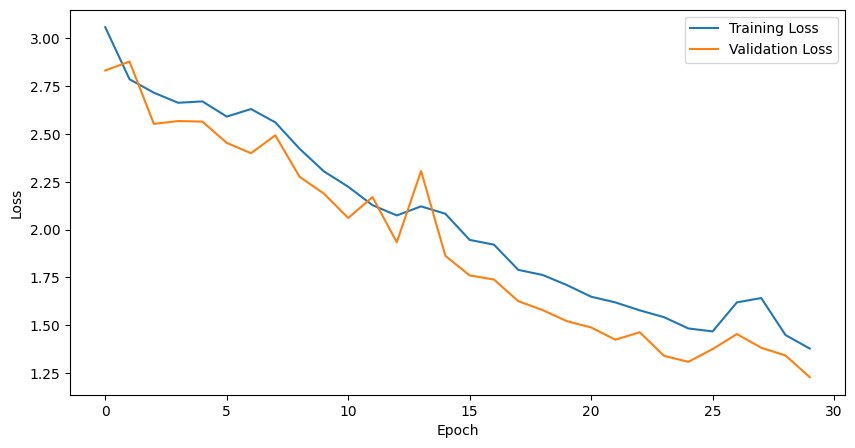

In [ ]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

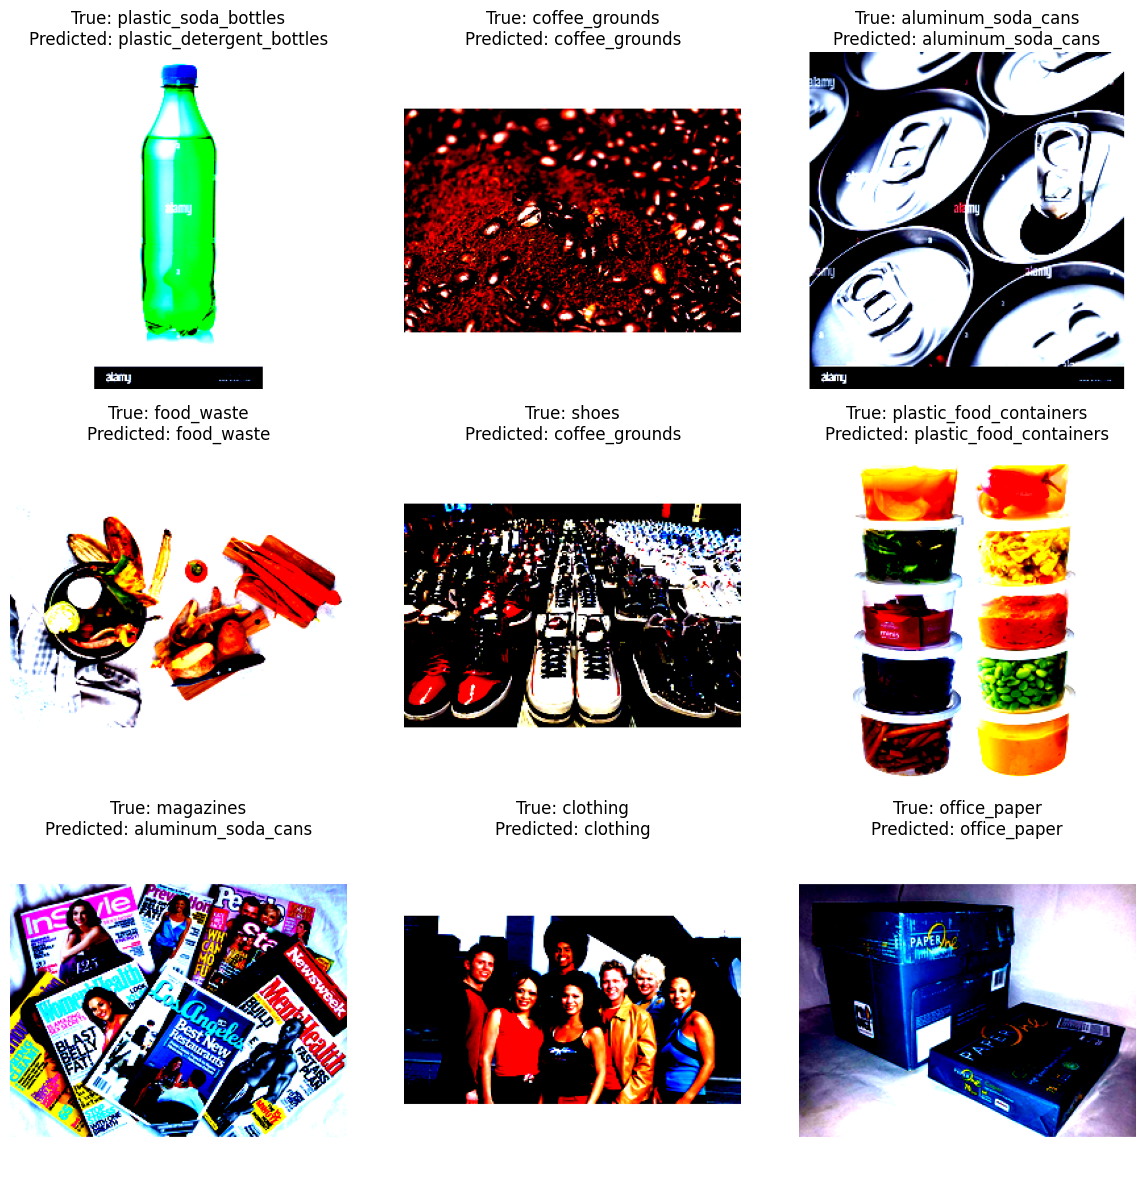

In [ ]:
# Perform sample inferences on random test images with different labels
model.eval()
with torch.no_grad():
    indices = list(range(len(test_dataset)))
    random.shuffle(indices)

    selected_images = []
    selected_labels = []
    selected_predicted = []

    for index in indices:
        image, label = test_dataset[index]
        image = image.unsqueeze(0).to('cuda')

        output = model(image)
        _, predicted = torch.max(output, 1)

        if label not in selected_labels:
            selected_images.append(image)
            selected_labels.append(label)
            selected_predicted.append(predicted.item())

        if len(selected_labels) == 9:
            break

    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()

    for i in range(9):
        axes[i].imshow(selected_images[i].squeeze().cpu().permute(1, 2, 0))
        axes[i].set_title(f"True: {train_dataset.classes[selected_labels[i]]}\nPredicted: {train_dataset.classes[selected_predicted[i]]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

# 정확도 계산
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to('cuda')
        labels = labels.to('cuda')

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # 예측 클래스 가져오기
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 63.00%


In [ ]:
import torch

# 체크포인트를 저장할 경로
checkpoint_path = 'checkpoint1.pth'

# 모델과 옵티마이저의 상태 저장
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
}, checkpoint_path)

print("현재 학습 상태가 저장되었습니다.")

현재 학습 상태가 저장되었습니다.


# checkpoint2


In [ ]:
checkpoint_path = 'checkpoint1.pth'
# 체크포인트가 존재하면 로드
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    print(f"체크포인트에서 에포크 {start_epoch}부터 이어서 학습합니다.")
else:
    start_epoch = 0
    train_losses = []
    val_losses = []
    print("새로운 학습을 시작합니다.")

체크포인트에서 에포크 30부터 이어서 학습합니다.


<ipython-input-18-c59945af7ee8>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


In [ ]:
start = time.time()
# 모델을 CUDA로 이동
model.to('cuda')

# 이어서 학습할 총 에포크 수 설정
total_epochs = 60  # 원하는 총 에포크 수로 설정하세요

# 학습 루프
for epoch in range(start_epoch, total_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for images, labels in train_dataloader:
        images = images.to('cuda')
        labels = labels.to('cuda')

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to('cuda')
            labels = labels.to('cuda')

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_dataset)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{total_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

print("학습이 완료되었습니다!")
end = time.time()
print("실행 시간:", end - start, "초")

Epoch [31/60], Train Loss: 1.3804, Val Loss: 1.1986
Epoch [32/60], Train Loss: 1.3952, Val Loss: 1.2793
Epoch [33/60], Train Loss: 1.3715, Val Loss: 1.1782
Epoch [34/60], Train Loss: 1.3318, Val Loss: 1.1579
Epoch [35/60], Train Loss: 1.2665, Val Loss: 1.1255
Epoch [36/60], Train Loss: 1.2522, Val Loss: 1.1106
Epoch [37/60], Train Loss: 1.2417, Val Loss: 1.1058
Epoch [38/60], Train Loss: 1.2145, Val Loss: 1.1257
Epoch [39/60], Train Loss: 1.1781, Val Loss: 1.0560
Epoch [40/60], Train Loss: 1.2161, Val Loss: 0.9967
Epoch [41/60], Train Loss: 1.1667, Val Loss: 1.0168
Epoch [42/60], Train Loss: 1.3234, Val Loss: 1.1480
Epoch [43/60], Train Loss: 1.2355, Val Loss: 1.0232
Epoch [44/60], Train Loss: 1.1513, Val Loss: 0.9779
Epoch [45/60], Train Loss: 1.1248, Val Loss: 0.9944
Epoch [46/60], Train Loss: 1.1142, Val Loss: 0.9703
Epoch [47/60], Train Loss: 1.1889, Val Loss: 0.9949
Epoch [48/60], Train Loss: 1.0653, Val Loss: 0.9240
Epoch [49/60], Train Loss: 1.0622, Val Loss: 0.9341
Epoch [50/60

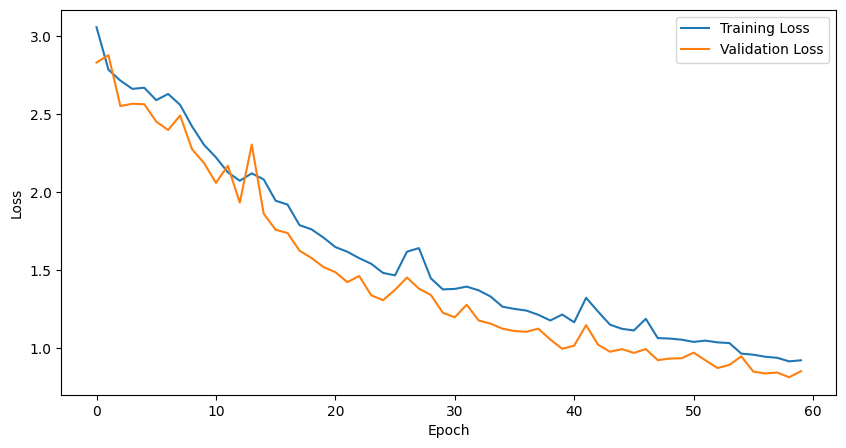

In [ ]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

# 정확도 계산
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to('cuda')
        labels = labels.to('cuda')

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # 예측 클래스 가져오기
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 73.13%


In [ ]:
import torch

# 체크포인트를 저장할 경로
checkpoint_path = 'checkpoint2.pth'

# 모델과 옵티마이저의 상태 저장
torch.save({
    'epoch': total_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
}, checkpoint_path)

print("현재 학습 상태가 저장되었습니다.")

현재 학습 상태가 저장되었습니다.


# checkpoint 3

In [ ]:
checkpoint_path = 'checkpoint2.pth'
# 체크포인트가 존재하면 로드
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    print(f"체크포인트에서 에포크 {start_epoch}부터 이어서 학습합니다.")
else:
    start_epoch = 0
    train_losses = []
    val_losses = []
    print("새로운 학습을 시작합니다.")

체크포인트에서 에포크 60부터 이어서 학습합니다.


<ipython-input-23-563523cdccda>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


In [ ]:
start = time.time()
# 모델을 CUDA로 이동
model.to('cuda')

# 이어서 학습할 총 에포크 수 설정
total_epochs = 80  # 원하는 총 에포크 수로 설정하세요

# 학습 루프
for epoch in range(start_epoch, total_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for images, labels in train_dataloader:
        images = images.to('cuda')
        labels = labels.to('cuda')

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to('cuda')
            labels = labels.to('cuda')

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_dataset)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{total_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

print("학습이 완료되었습니다!")
end = time.time()
print("실행 시간:", end - start, "초")

Epoch [61/80], Train Loss: 0.9178, Val Loss: 0.7874
Epoch [62/80], Train Loss: 0.8922, Val Loss: 0.7872
Epoch [63/80], Train Loss: 0.8620, Val Loss: 0.7562
Epoch [64/80], Train Loss: 0.8697, Val Loss: 0.7863
Epoch [65/80], Train Loss: 0.8628, Val Loss: 0.7884
Epoch [66/80], Train Loss: 0.9162, Val Loss: 0.9144
Epoch [67/80], Train Loss: 1.2252, Val Loss: 1.0905
Epoch [68/80], Train Loss: 1.0049, Val Loss: 0.8530
Epoch [69/80], Train Loss: 0.8939, Val Loss: 0.7818
Epoch [70/80], Train Loss: 0.8489, Val Loss: 0.7543
Epoch [71/80], Train Loss: 0.8310, Val Loss: 0.7488
Epoch [72/80], Train Loss: 0.7988, Val Loss: 0.8003
Epoch [73/80], Train Loss: 0.8085, Val Loss: 0.7255
Epoch [74/80], Train Loss: 0.7893, Val Loss: 0.6966
Epoch [75/80], Train Loss: 0.7756, Val Loss: 0.7138
Epoch [76/80], Train Loss: 0.7610, Val Loss: 0.7639
Epoch [77/80], Train Loss: 0.7760, Val Loss: 0.7320
Epoch [78/80], Train Loss: 0.7636, Val Loss: 0.7057
Epoch [79/80], Train Loss: 0.8529, Val Loss: 0.7033
Epoch [80/80

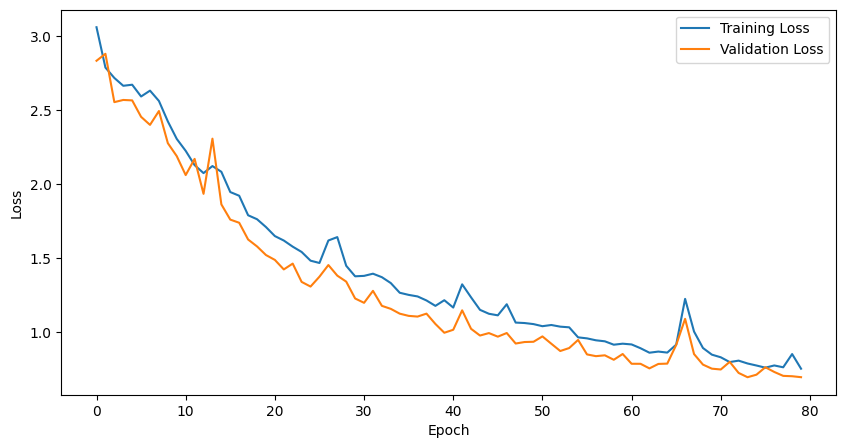

In [ ]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

# 정확도 계산
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to('cuda')
        labels = labels.to('cuda')

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # 예측 클래스 가져오기
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 77.67%


In [ ]:
import torch

# 체크포인트를 저장할 경로
checkpoint_path = 'checkpoint3.pth'

# 모델과 옵티마이저의 상태 저장
torch.save({
    'epoch': total_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
}, checkpoint_path)

print("현재 학습 상태가 저장되었습니다.")

현재 학습 상태가 저장되었습니다.


# checkpoint4


In [ ]:
checkpoint_path = 'checkpoint3.pth'
# 체크포인트가 존재하면 로드
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    print(f"체크포인트에서 에포크 {start_epoch}부터 이어서 학습합니다.")
else:
    start_epoch = 0
    train_losses = []
    val_losses = []
    print("새로운 학습을 시작합니다.")

체크포인트에서 에포크 80부터 이어서 학습합니다.


<ipython-input-28-ee0be5d2c316>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


In [ ]:
start = time.time()
# 모델을 CUDA로 이동
model.to('cuda')

# 이어서 학습할 총 에포크 수 설정
total_epochs = 100  # 원하는 총 에포크 수로 설정하세요

# 학습 루프
for epoch in range(start_epoch, total_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for images, labels in train_dataloader:
        images = images.to('cuda')
        labels = labels.to('cuda')

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to('cuda')
            labels = labels.to('cuda')

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_dataset)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{total_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

print("학습이 완료되었습니다!")
end = time.time()
print("실행 시간:", end - start, "초")

Epoch [81/100], Train Loss: 0.7300, Val Loss: 0.7039
Epoch [82/100], Train Loss: 0.7383, Val Loss: 0.7200
Epoch [83/100], Train Loss: 0.7399, Val Loss: 0.6908
Epoch [84/100], Train Loss: 0.7427, Val Loss: 0.6839
Epoch [85/100], Train Loss: 0.7438, Val Loss: 0.6738
Epoch [86/100], Train Loss: 0.6992, Val Loss: 0.6683
Epoch [87/100], Train Loss: 0.7253, Val Loss: 0.6804
Epoch [88/100], Train Loss: 0.7108, Val Loss: 0.6694
Epoch [89/100], Train Loss: 0.6882, Val Loss: 0.7729
Epoch [90/100], Train Loss: 0.7065, Val Loss: 0.6344
Epoch [91/100], Train Loss: 0.6634, Val Loss: 0.6385
Epoch [92/100], Train Loss: 0.6974, Val Loss: 0.6466
Epoch [93/100], Train Loss: 0.6383, Val Loss: 0.6378
Epoch [94/100], Train Loss: 0.6653, Val Loss: 0.6823
Epoch [95/100], Train Loss: 0.6659, Val Loss: 0.6561
Epoch [96/100], Train Loss: 0.6409, Val Loss: 0.6483
Epoch [97/100], Train Loss: 0.6529, Val Loss: 0.6172
Epoch [98/100], Train Loss: 0.6659, Val Loss: 0.6376
Epoch [99/100], Train Loss: 0.6879, Val Loss: 

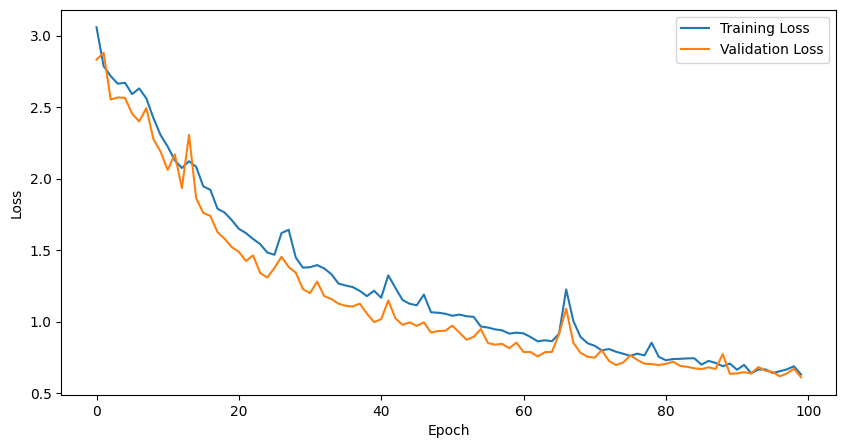

In [ ]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

# 정확도 계산
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to('cuda')
        labels = labels.to('cuda')

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # 예측 클래스 가져오기
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 83.30%


In [ ]:
import torch

# 체크포인트를 저장할 경로
checkpoint_path = 'checkpoint4.pth'

# 모델과 옵티마이저의 상태 저장
torch.save({
    'epoch': total_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
}, checkpoint_path)

print("현재 학습 상태가 저장되었습니다.")

현재 학습 상태가 저장되었습니다.


# checkpoint5


In [ ]:
checkpoint_path = 'checkpoint4.pth'
# 체크포인트가 존재하면 로드
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    print(f"체크포인트에서 에포크 {start_epoch}부터 이어서 학습합니다.")
else:
    start_epoch = 0
    train_losses = []
    val_losses = []
    print("새로운 학습을 시작합니다.")

체크포인트에서 에포크 100부터 이어서 학습합니다.


<ipython-input-32-6fa2b7a554ed>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


In [ ]:
start = time.time()
# 모델을 CUDA로 이동
model.to('cuda')

# 이어서 학습할 총 에포크 수 설정
total_epochs = 120  # 원하는 총 에포크 수로 설정하세요

# 학습 루프
for epoch in range(start_epoch, total_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for images, labels in train_dataloader:
        images = images.to('cuda')
        labels = labels.to('cuda')

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to('cuda')
            labels = labels.to('cuda')

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_dataset)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{total_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

print("학습이 완료되었습니다!")
end = time.time()
print("실행 시간:", end - start, "초")

Epoch [101/120], Train Loss: 0.6066, Val Loss: 0.6592
Epoch [102/120], Train Loss: 0.6593, Val Loss: 0.6017
Epoch [103/120], Train Loss: 0.6050, Val Loss: 0.6086
Epoch [104/120], Train Loss: 0.6064, Val Loss: 0.5987
Epoch [105/120], Train Loss: 0.5906, Val Loss: 0.6155
Epoch [106/120], Train Loss: 0.6326, Val Loss: 0.6088
Epoch [107/120], Train Loss: 0.5858, Val Loss: 0.5806
Epoch [108/120], Train Loss: 0.5613, Val Loss: 0.6101
Epoch [109/120], Train Loss: 0.5983, Val Loss: 0.5899
Epoch [110/120], Train Loss: 0.5767, Val Loss: 0.5953
Epoch [111/120], Train Loss: 0.5755, Val Loss: 0.5776
Epoch [112/120], Train Loss: 0.5722, Val Loss: 0.6236
Epoch [113/120], Train Loss: 0.6940, Val Loss: 0.6684
Epoch [114/120], Train Loss: 0.6452, Val Loss: 0.6207
Epoch [115/120], Train Loss: 0.5973, Val Loss: 0.6023
Epoch [116/120], Train Loss: 0.5624, Val Loss: 0.6168
Epoch [117/120], Train Loss: 0.5323, Val Loss: 0.5658
Epoch [118/120], Train Loss: 0.5201, Val Loss: 0.5596
Epoch [119/120], Train Loss:

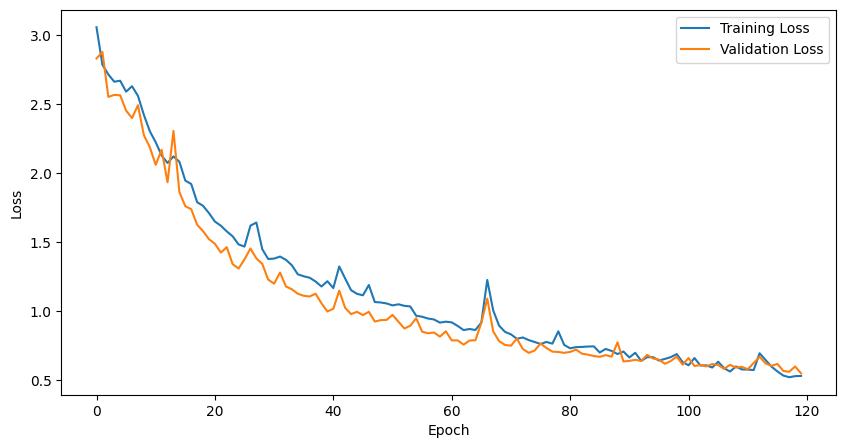

In [ ]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

# 정확도 계산
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to('cuda')
        labels = labels.to('cuda')

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # 예측 클래스 가져오기
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 83.30%


In [ ]:
import torch

# 체크포인트를 저장할 경로
checkpoint_path = 'checkpoint5.pth'

# 모델과 옵티마이저의 상태 저장
torch.save({
    'epoch': total_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
}, checkpoint_path)

print("현재 학습 상태가 저장되었습니다.")

현재 학습 상태가 저장되었습니다.


In [ ]:
from google.colab import files

# 다운로드할 파일 이름
filename = "/content/checkpoint4.pth"

# 파일 다운로드
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

# 다운로드할 파일 이름
filename = "/content/checkpoint5.pth"

# 파일 다운로드
files.download(filename)

FileNotFoundError: Cannot find file: /content/checkpoint5.pth

# inference time



In [ ]:
image_path = '/content/data/images/images/aerosol_cans/real_world/Image_1.png'  # 여기에 이미지 파일 경로 입력

input_data = Image.open(image_path)
input_data = val_transform(input_data).unsqueeze(0).to('cuda')
input_data.shape

torch.Size([1, 3, 256, 256])

In [ ]:
import torch.profiler

with torch.profiler.profile(
    activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
    record_shapes=True,
    profile_memory=True
) as prof:
    with torch.no_grad():
        output = model(input_data)

print(prof.key_averages().table(sort_by="self_cpu_time_total"))


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                aten::cudnn_convolution        23.01%       6.004ms        30.50%       7.959ms     215.101us     538.939us        23.76%     538.939us      14.566us           0 b           0 b      31.00 Mb      31.00 M